In [1]:
import kagglehub
kazanova_sentiment140_path = kagglehub.dataset_download('kazanova/sentiment140')

print('Data source import complete.')


Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

from sklearn.utils import resample  

from sklearn.model_selection import train_test_split    
from sklearn.metrics import (accuracy_score, precision_score,        
                             recall_score, f1_score,
                             confusion_matrix, classification_report)

from sklearn.feature_extraction.text import TfidfVectorizer           

from tensorflow.keras.preprocessing.text import Tokenizer             
from tensorflow.keras.preprocessing.sequence import pad_sequences      


# EDA

In this data preparation phase, we import the Sentiment140 dataset and configure appropriate column headers to facilitate analysis. To optimize computational efficiency while preserving statistical significance, we extract a balanced random sample of 1,000,000 tweets from the full corpus. We conduct exploratory data analysis to examine the dataset's structural characteristics, particularly focusing on sentiment class distribution to ensure representativeness. The final step involves partitioning the data into stratified training and testing sets using an 80:20 ratio, which maintains proportional representation of positive and negative sentiment classes in both subsets, thus providing a robust foundation for model development and evaluation.


   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------

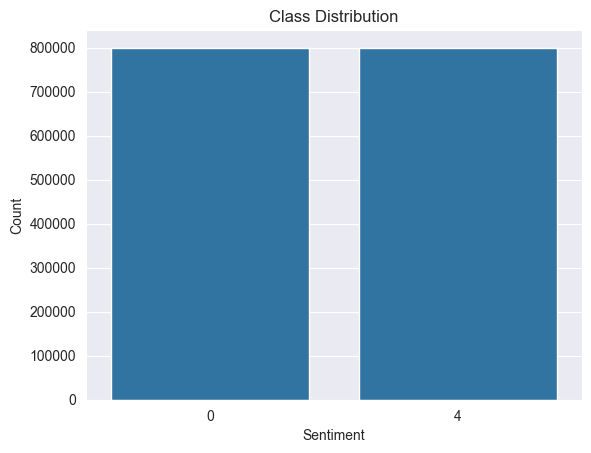

In [4]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding='latin-1', header=None)

df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

print(df.head())

print(df.info())

print(df['target'].value_counts())

sns.countplot(x='target', data=df)
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

train_df, test_df = train_test_split(
    df,
    test_size=200000,
    random_state=42,
    stratify=df['target']
)


# Feature Engineering

In this step, we perform basic text cleaning to prepare the tweets for modeling. We remove all irrelevant columns: URLs, mentions, hashtags, punctuation, and convert all text to lowercase. We also download the required NLTK resources such as stopwords and tokenizers. After cleaning, we apply the function to both training and testing datasets. Finally, we check the class distribution to identify any imbalance.


In [5]:

import nltk
nltk.download('stopwords')
nltk.download('punkt') 

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)        # Remove user mentions
    text = re.sub(r'#', '', text)           # Remove hashtag symbol but keep the word
    text = re.sub(r'[^\w\s]', '', text)     # Remove punctuation
    text = text.lower()                     # Convert text to lowercase
    return text

train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

print(train_df['target'].value_counts())


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yifei.hu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yifei.hu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


target
0    700000
4    700000
Name: count, dtype: int64


# Tokenization and Padding

We tokenize cleaned tweets using Keras' Tokenizer, fitting it exclusively on training data to prevent data leakage. The tokenizer converts words to integer indices, transforming text into numerical sequences. We then standardize input dimensions by padding all sequences to a uniform length, ensuring compatibility with neural network architecture requirements. Finally, we normalize the sentiment labels from their original values (0 and 4) to binary format (0 and 1) for classification purposes.

In [6]:

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>") 
tokenizer.fit_on_texts(train_df['cleaned_text'])

train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

max_len = 300
X_train = pad_sequences(train_sequences, maxlen=max_len, padding='post')
X_test = pad_sequences(test_sequences, maxlen=max_len, padding='post')

y_train = train_df['target'].replace({4: 1})
y_test = test_df['target'].replace({4: 1})


## Baseline model: Logistic Regression (From Scratch with Averaged Embeddings)

As our baseline, we implement Logistic Regression from scratch using NumPy. However, directly using padded integer sequences as input features for Logistic Regression is problematic due to the lack of meaningful numerical relationships between token indices and potential numerical instability.

A better approach, aligning with our proposal's mention of using embeddings, is to first convert the integer sequences into dense word embedding vectors and then aggregate these vectors into a single feature vector for each tweet. We will use the average of the word embeddings in a tweet as its feature representation. This captures semantic information more effectively than raw indices and provides a more suitable input for Logistic Regression.

First, we need to obtain the embedding vectors for our sequences. We can use a Keras `Embedding` layer for this. Then, we'll average these embeddings for each tweet.

In [10]:
import numpy as np
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
import gc

embedding_dim = 128
vocab_size = 10000 
max_len = 500 
batch_size = 4096*2

embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len,
                            mask_zero=True)
temp_model = Sequential([embedding_layer])
temp_model.build(input_shape=(None, max_len))

def masked_mean(embeddings, mask):
    mask = np.expand_dims(mask.astype(np.float32), axis=-1)
    
    masked_embeddings = embeddings * mask

    sum_embeddings = np.sum(masked_embeddings, axis=1)

    sum_mask = np.sum(mask, axis=1)
    
    sum_mask = np.maximum(sum_mask, 1e-9)
    
    return sum_embeddings / sum_mask


def generate_averaged_embeddings_batched(X_padded, batch_size, model, max_len):


    num_samples = X_padded.shape[0]
    averaged_embeddings_list = [] 
    
    print(f"Processing {num_samples} samples in batches of {batch_size}...")

    num_batches = (num_samples + batch_size - 1) // batch_size 
    
    for i in range(0, num_samples, batch_size):
        batch_start = i
        batch_end = min(i + batch_size, num_samples)
        X_batch = X_padded[batch_start:batch_end]


        embed_batch = model.predict(X_batch, batch_size=batch_size, verbose=0)
        
        mask_batch = (X_batch != 0)

        avg_embed_batch = masked_mean(embed_batch, mask_batch)

        averaged_embeddings_list.append(avg_embed_batch)

        del X_batch, embed_batch, mask_batch, avg_embed_batch
        gc.collect()

        current_batch_num = (i // batch_size) + 1
        if current_batch_num % 50 == 0 or current_batch_num == num_batches: 
            
             print(f"  Processed batch {current_batch_num} / {num_batches}")

    print("Batch processing complete. Concatenating results...")
    averaged_embeddings = np.concatenate(averaged_embeddings_list, axis=0)
    print("Concatenation complete.")
    return averaged_embeddings

print("Generating averaged embeddings for Training set...")
X_train_embed_avg = generate_averaged_embeddings_batched(X_train, batch_size, temp_model, max_len)

print("\nGenerating averaged embeddings for Test set...")
X_test_embed_avg = generate_averaged_embeddings_batched(X_test, batch_size, temp_model, max_len)

print("\nShape of final X_train_embed_avg:", X_train_embed_avg.shape)
print("Shape of final X_test_embed_avg:", X_test_embed_avg.shape)  

print("\nScaling features...")
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_embed_avg)

X_test_scaled = scaler.transform(X_test_embed_avg)

print("Scaled training data shape:", X_train_scaled.shape)
print("Scaled testing data shape:", X_test_scaled.shape)


print("\nCleaning up intermediate variables...")
del X_train_embed_avg, X_test_embed_avg
gc.collect()

print("Feature generation and scaling complete.")

/Users/yifei.hu/NoUpdate/Python/AML/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Generating averaged embeddings for Training set...
Processing 1400000 samples in batches of 8192...
  Processed batch 50 / 171
  Processed batch 100 / 171
  Processed batch 150 / 171
  Processed batch 171 / 171
Batch processing complete. Concatenating results...
Concatenation complete.

Generating averaged embeddings for Test set...
Processing 200000 samples in batches of 8192...
  Processed batch 25 / 25
Batch processing complete. Concatenating results...
Concatenation complete.

Shape of final X_train_embed_avg: (1400000, 128)
Shape of final X_test_embed_avg: (200000, 128)

Scaling features...
Scaled training data shape: (1400000, 128)
Scaled testing data shape: (200000, 128)

Cleaning up intermediate variables...
Feature generation and scaling complete.


Now, we define our Logistic Regression class implemented from scratch. This class encapsulates the sigmoid function, prediction logic, gradient calculation, weight updates (using gradient ascent), and the fitting process. We include options for L2 regularization and track the cost history. Using a class structure makes the code cleaner and reusable.

In [11]:
# Code Block 2: Logistic Regression from Scratch Clas
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, epochs=1000, reg_lambda=0.01, verbose_step=100):


        self.learning_rate = learning_rate
        self.epochs = epochs
        self.reg_lambda = reg_lambda
        self.weights = None
        self.bias = None
        self.cost_history = []
        self.verbose_step = verbose_step

    def _sigmoid(self, z):
        
        z_clipped = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z_clipped))

    def _compute_cost(self, X, y):
        
        m = X.shape[0]
        z = X.dot(self.weights) + self.bias
        h = self._sigmoid(z)


        epsilon = 1e-15
        cost = -(1/m) * np.sum(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))


        if self.reg_lambda > 0:
            l2_term = (self.reg_lambda / (2 * m)) * np.sum(np.square(self.weights))
            cost += l2_term

        return cost

    def fit(self, X, y):
        
        num_samples, num_features = X.shape


        self.weights = np.zeros(num_features)
        self.bias = 0
        self.cost_history = []


        for i in range(self.epochs):
            
            z = X.dot(self.weights) + self.bias
            h = self._sigmoid(z)


            dw = (1 / num_samples) * X.T.dot(h - y)
            db = (1 / num_samples) * np.sum(h - y)


            if self.reg_lambda > 0:
                dw += (self.reg_lambda / num_samples) * self.weights


            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db


            cost = self._compute_cost(X, y)
            self.cost_history.append(cost)


            if self.verbose_step > 0 and (i + 1) % self.verbose_step == 0:
                print(f"Epoch {i+1}/{self.epochs}, Cost: {cost:.6f}")

    def predict_proba(self, X):
        
        z = X.dot(self.weights) + self.bias
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

Finally, we instantiate our `LogisticRegressionScratch` class, train it on the scaled averaged embedding features, and evaluate its performance on the test set using standard classification metrics. We also visualize the confusion matrix and the cost decrease during training.

Training Logistic Regression (from scratch) on averaged embeddings...
Epoch 100/500, Cost: 0.666295
Epoch 200/500, Cost: 0.658065
Epoch 300/500, Cost: 0.653939
Epoch 400/500, Cost: 0.651360
Epoch 500/500, Cost: 0.649565

Making predictions...

Baseline Model (Logistic Regression from Scratch w/ Avg Embeddings) Evaluation:
Accuracy:  0.6222
Precision: 0.6238
Recall:    0.6157
F1-Score:  0.6197


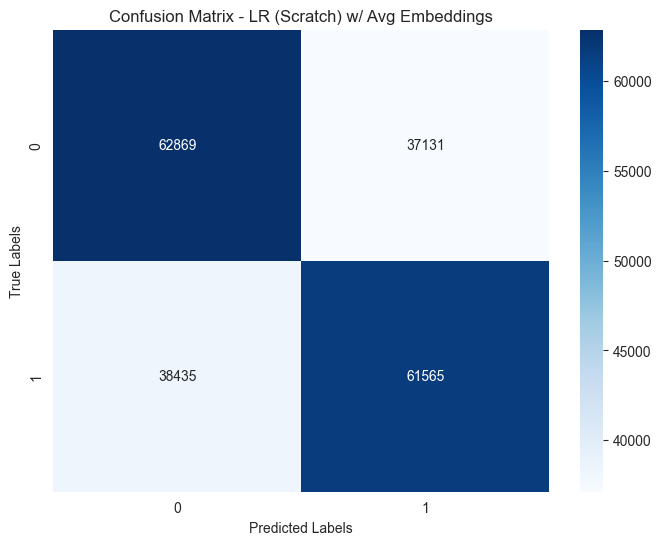

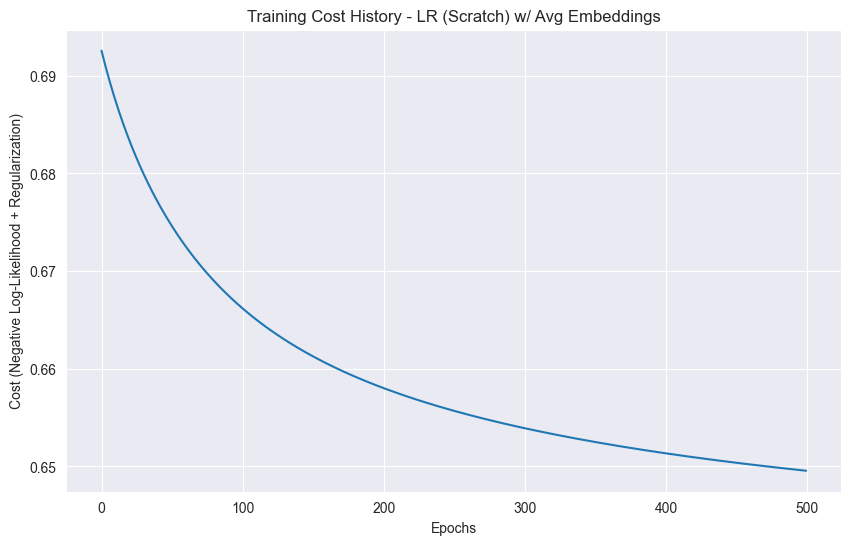

In [12]:


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


y_train_np = np.array(y_train)
y_test_np = np.array(y_test)



learning_rate = 0.01
epochs = 500     
reg_lambda = 0.1  
verbose_step = 100


baseline_model_embed = LogisticRegressionScratch(learning_rate=learning_rate,
                                                epochs=epochs,
                                                reg_lambda=reg_lambda,
                                                verbose_step=verbose_step)

print("Training Logistic Regression (from scratch) on averaged embeddings...")
baseline_model_embed.fit(X_train_scaled, y_train_np)


print("\nMaking predictions...")
y_pred_embed = baseline_model_embed.predict(X_test_scaled)


print("\nBaseline Model (Logistic Regression from Scratch w/ Avg Embeddings) Evaluation:")

accuracy = accuracy_score(y_test_np, y_pred_embed)

precision = precision_score(y_test_np, y_pred_embed, zero_division=0)
recall = recall_score(y_test_np, y_pred_embed, zero_division=0)
f1 = f1_score(y_test_np, y_pred_embed, zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test_np, y_pred_embed)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - LR (Scratch) w/ Avg Embeddings')
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(baseline_model_embed.cost_history)
plt.title('Training Cost History - LR (Scratch) w/ Avg Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Cost (Negative Log-Likelihood + Regularization)')
plt.grid(True)
plt.show()

## Logistic Regression with TF-IDF Features
#Best
#so
#far
Instead of sequences, we use TF-IDF to represent the text, capturing word importance based on frequency. This method often works well with classical models like Logistic Regression. We then train and evaluate the model to compare its performance with the sequence-based approach.

Converting text to TF-IDF features...
TF-IDF features shape: (1400000, 1000)
Training logistic regression model on TF-IDF features...
Making predictions...

Model Evaluation Metrics:
Accuracy:  0.7088
Precision: 0.7086
Recall:    0.7093
F1-Score:  0.7089


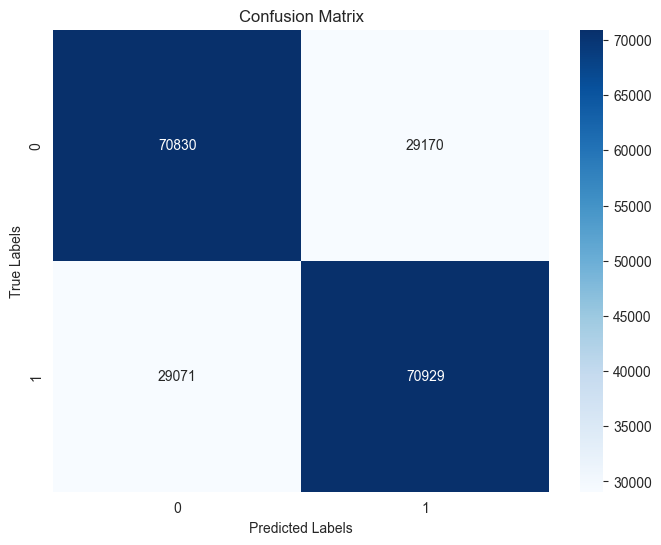

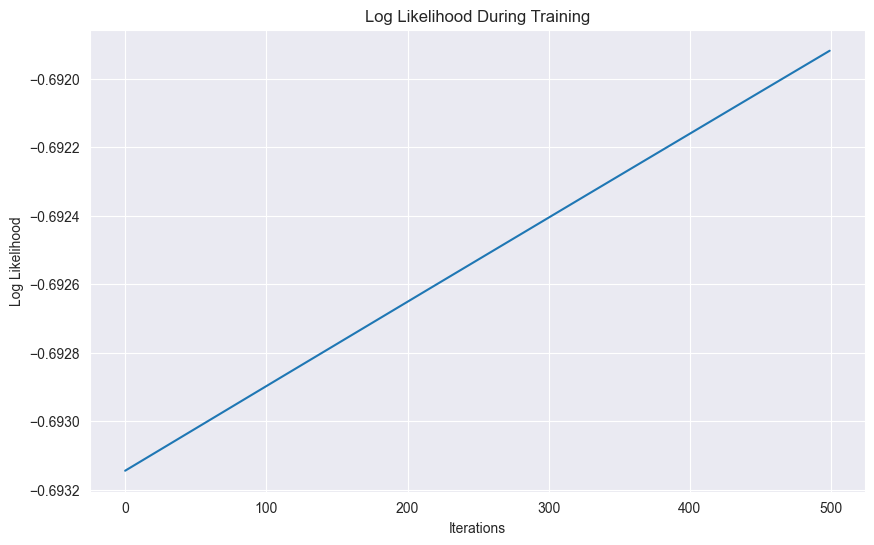


Top 10 negative features:
miss: -0.0185
sad: -0.0173
work: -0.0159
dont: -0.0131
wish: -0.0121
want: -0.0115
sorry: -0.0110
im: -0.0107
hate: -0.0106
bad: -0.0101

Top 10 positive features:
nice: 0.0074
haha: 0.0079
awesome: 0.0079
lol: 0.0080
happy: 0.0097
great: 0.0111
thank: 0.0121
good: 0.0192
love: 0.0195
thanks: 0.0230


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

def compute_log_likelihood(X, Y, W):

    lp=None
    indicator = (Y==+1)
    scores = np.dot(X, W)
    logexp = np.log(1. + np.exp(-scores))
    
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    lp = np.sum((indicator-1)*scores - logexp)/len(X)
    return lp

def update_weights(X, Y, W, b, learning_rate, log_likelihood):
    
    num_features, num_examples = X.shape
    
    y_pred = 1 / (1 + np.exp(-(X.dot(W) + b)))

    dW = X.T.dot(Y-y_pred) / num_features
    db = np.sum(Y-y_pred) / num_features


    b = b + learning_rate * db
    W = W + learning_rate * dW


    log_likelihood = compute_log_likelihood(X, Y, W)

    return W, b, log_likelihood

def predict(X, W, b):

    scores = np.clip(X.dot(W) + b, -500, 500)
    Z = 1 / (1 + np.exp(-scores))
    Y = [0 if z <= 0.5 else 1 for z in Z]
    return Y

def fit(X, Y, num_iterations, learning_rate=1e-3, verbose=True):

    num_features, num_examples = X.shape

    W = np.zeros(num_examples)
    b = 0
    log_likelihood=0
    likelihood_history=[]

    for i in range(num_iterations):
        W, b, log_likelihood = update_weights(X, Y, W, b, learning_rate, log_likelihood)
        likelihood_history.append(log_likelihood)
    return W, b, likelihood_history


if __name__ == "__main__":

    learning_rate = 0.01
    num_iterations = 500
    max_features = 1000
    
    print("Converting text to TF-IDF features...")
    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words='english',
        min_df=5  
    )

    X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_text'])
    X_test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_text'])

    X_train_tfidf = X_train_tfidf.toarray()
    X_test_tfidf = X_test_tfidf.toarray()

    print(f"TF-IDF features shape: {X_train_tfidf.shape}")

    print("Training logistic regression model on TF-IDF features...")
    sentiment_model_weights, sentiment_model_bias, likelihood_history = fit(
        X_train_tfidf, y_train, num_iterations, learning_rate
    )

    print("Making predictions...")
    y_pred = predict(X_test_tfidf, sentiment_model_weights, sentiment_model_bias)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print("\nModel Evaluation Metrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(likelihood_history)
    plt.title('Log Likelihood During Training')
    plt.xlabel('Iterations')
    plt.ylabel('Log Likelihood')
    plt.grid(True)
    plt.show()

    if hasattr(tfidf_vectorizer, 'get_feature_names_out'):
        feature_names = tfidf_vectorizer.get_feature_names_out()
    else:
        feature_names = tfidf_vectorizer.get_feature_names()

    top_n = 10
    sorted_indices = np.argsort(sentiment_model_weights)

    print(f"\nTop {top_n} negative features:")
    for idx in sorted_indices[:top_n]:
        print(f"{feature_names[idx]}: {sentiment_model_weights[idx]:.4f}")

    print(f"\nTop {top_n} positive features:")
    for idx in sorted_indices[-top_n:]:
        print(f"{feature_names[idx]}: {sentiment_model_weights[idx]:.4f}")
